# WEFE Site Analyst
## implemented in Jupyter Notebook

This Jupyter Notebook collects environmental and socioeconomic data for the planning of integrated water, energy, food, and environment systems from open servers.

In [1]:
# imports
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import os
from math import sqrt
import numpy as np
import folium
#import geojson
import overpy
import geemap
import geemap.foliumap as gfolium
import json
import requests
import ee
import webbrowser



from geemap import geojson_to_ee, ee_to_geojson
from ipyleaflet import GeoJSON

from geopandas import GeoDataFrame

import shapely
from shapely.geometry import Polygon, shape
from shapely.geometry import LineString

# to generate word report
from docx import Document
from docx.shared import Pt, Inches, RGBColor
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.table import WD_ALIGN_VERTICAL
from io import BytesIO

# import files from source
os.chdir("../../src/")
import era5
import ee_layer
os.chdir("../examples/India")

In [2]:
# Update geemap package in case of errors

# geemap.update_package()

In [3]:
# set start and end date (end date will be included
# in the time period for which data is downloaded)
start_date, end_date = '2022-01-01', '2022-12-31'  # time in UTC choose start date one day before time of interest
# for position east of 0° meridian for covering all hours of interest

In [4]:
# initiate earth engine

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [5]:
# provide case study name and coordiantes

name = input("Enter the name of the case study: ")
lat = float(input("Enter the latitude: "))
lon = float(input("Enter the longitude: "))

center = ee.Geometry.Point(lon, lat)

# add function to add polygon representing the parcel in case user wants it

# visualization as geemap
satellite_map = geemap.Map(center=[lat, lon], zoom=16)
satellite_map.add_basemap('SATELLITE')
satellite_map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")
# map.add_layer(json_shape_layer)

# Display the map
satellite_map

Enter the name of the case study:  masma
Enter the latitude:  21.298016354987144
Enter the longitude:  72.76119193635735


Map(center=[21.298016354987144, 72.76119193635735], controls=(WidgetControl(options=['position', 'transparent_…

In [6]:
# Save the map in folder 'interactive_html'
satellite_map.save('interactive_htmls/satellite_map.html')

In [7]:
## TERRAIN MAP
# Define the location for which you want to create the elevation map (given abo)

# Create a single central point based on given coordinates
center = ee.Geometry.Point(lon, lat)
# Create a buffer which definies the area of interest for calculating min/max elevation, in meters in this case
buffer = center.buffer(distance=10000)

# Get the digital elevation model from earth engine
elevation = ee.Image('USGS/SRTMGL1_003')
# Create a feature, in this case the center point based on given coordinates
central_feature = ee.Feature(center, {'latitude': lat, 'longitude': lon})
# Create a feature collection from the central point, in this case the feature collection only contains one feature
fc = ee.FeatureCollection(central_feature)
# Extract elevation from digital elevation model at the central point, a scale of 30 meters is used
reducer = ee.Reducer.first()
data = elevation.reduceRegions(fc, reducer.setOutputs(['elevation']), 10)
# Get the central feature in the data, which is the first (and only) feature
feature_center = ee.Feature(data.first())
# Get the 'elevation' property from the feature
elevation_value = feature_center.get('elevation')
# Print the elevation value
print(f'Elevation at ({lat}, {lon}): {elevation_value.getInfo()} meters')

# Create a geemap map centered on the location
terrain_map = geemap.Map(center=[lat, lon], zoom=16)

# Use the 'SRTM 30m Digital Elevation Database' dataset to get elevation dataset for the buffer area
elevation_buffer_area = ee.Image('USGS/SRTMGL1_003').clip(buffer)
# Calculate statistics (min and max) for elevation within the buffer
stats = elevation_buffer_area.reduceRegion(reducer=ee.Reducer.minMax(), geometry=buffer, scale=10)
# Get minimum and maximum elevation info
min_elevation = stats.getNumber('elevation_min')
max_elevation = stats.getNumber('elevation_max')
# Get minimum and maximum elevation values
min_elevation_value = min_elevation.getInfo()
max_elevation_value = max_elevation.getInfo()
# Print the min and max elevation values
print(f'Minimum Elevation in surrounding area: {min_elevation_value} meters')
print(f'Maximum Elevation in surrounding area: {max_elevation_value} meters')

slope = ee.Terrain.slope(elevation)
# Calculate aspect. Units are degrees where 0=N, 90=E, 180=S, 270=W.
aspect = ee.Terrain.aspect(elevation);
terrain = ee.Terrain.products(elevation);

# Update visaulisation parameters based on the min and max elevation values
vis_params = {
    'min': min_elevation_value,
    'max': max_elevation_value,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

# Update visualisation parameters for the slopes in the map
vis_params_slope = {
    'min': 0,
    'max': 20,
    'palette': ['FFFFFF', '000000'],
}
terrain_map.add_basemap('SATELLITE')
terrain_map.addLayer(slope,{'min': 0, 'max': 20, 'palette': ['FFFFFF', '000000']}, 'Slope')
terrain_map.addLayer(aspect,{'min': 0, 'max': 360, 'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']}, 'Aspect')
terrain_map.addLayer(terrain.select('hillshade'), {min: 0, max: 255}, 'Hillshade')
terrain_map.addLayer(elevation, vis_params, 'Elevation')
terrain_map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")

# Make pixels with elevation below sea level transparent -> please implement
# elv_img = srtm.updateMask(srtm.gt(0))

colors = vis_params['palette']
vmin = vis_params['min']
vmax = vis_params['max']

terrain_map.add_colorbar_branca(vis_params = vis_params, colors=colors, vmin=vmin, vmax=vmax, layer_name="Elevation")

# Display the map
terrain_map

#image = terrain_map.clip(buffer).unmask()
#geemap.ee_export_image(
#image, filename='test_map.tif', scale=90, region=buffer, file_per_band=False
#)

Elevation at (21.298016354987144, 72.76119193635735): 8 meters
Minimum Elevation in surrounding area: -20 meters
Maximum Elevation in surrounding area: 58 meters


Map(center=[21.298016354987144, 72.76119193635735], controls=(WidgetControl(options=['position', 'transparent_…

In [8]:
# Save the map in folder 'interactive_html'
terrain_map.save('interactive_htmls/terrain_map.html')

In [9]:
## LANDUSE MAP
# Define the location for which you want to create the map

center = ee.Geometry.Point(lon, lat)
buffer = center.buffer(3000)

landuse_map = geemap.Map(center=[lat, lon], zoom=16)
dataset = ee.ImageCollection("ESA/WorldCover/v100").first()
landuse_map.add_basemap('SATELLITE')
landuse_map.addLayer(dataset, {'bands': ['Map']}, 'ESA Land Cover')
landuse_map.add_legend(builtin_legend='ESA_WorldCover')
landuse_map.addLayer(center,{'color': 'red', 'weight': 1, 'opacity': 1}, "center")

# Display the map
landuse_map

Map(center=[21.298016354987144, 72.76119193635735], controls=(WidgetControl(options=['position', 'transparent_…

In [10]:
# Save the map in folder 'interactive_html'
landuse_map.save('interactive_htmls/landuse_map.html')

In [11]:
# Hydrology Map

case_study = ee.Geometry.Point(lon, lat)

hydrology_map = geemap.Map(
    case_study=[lat, lon], zoom=1, toolbar_control=False, layers_control=True
)

hydrology_map.add_basemap('SATELLITE')

hydrology_map.add_osm_from_point(
    center_point=(lat, lon),
    tags={"natural": "water"},
    dist=10000,
    layer_name="water bodies", 
    style={'color': '#224B99'}
)

hydrology_map.add_osm_from_point(
    center_point=(lat, lon),
    tags={"waterway":["river", "stream", "tidal_channel", "canal", "ditch", "drain", "pressurized"]},
    dist=10000,
    layer_name="waterways",
    style={'color': '#097FFD'}  # Define the color for waterways - light blue color
)

hydrology_map.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 0.7}, "case_study")

# Display the map
hydrology_map

# "amenity":"drinking_water"
#waterway=river waterway=streamwaterway=tidal_channel waterway=canal waterway=ditch waterway=drain waterway=pressurised
#natural=water
#water=*

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [12]:
# Save the map in folder 'interactive_html'
hydrology_map.save('interactive_htmls/hydrology_map.html')

In [13]:
# Use of Selenium and Time to convert interactive html maps to static screenshots
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PIL import Image
import time

# Path to the Geckodriver (https://sourceforge.net/projects/geckodriver.mirror/), differs for each Webbrowser
driver_path = r'C:\Users\Vivek.Rana\Desktop\dsk\Solvers\geckodriver-v0.34.0-win64\geckodriver.exe'

# Set up the Selenium driver for Firefox in default
service = Service(executable_path=driver_path)
options = webdriver.FirefoxOptions()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--window-size=1200x800')
driver = webdriver.Firefox(service=service, options=options)

# List of HTML files to convert
html_files = [
    r'C:\Users\Vivek.Rana\Desktop\Projects\WEFESA\WEFESiteAnalyst\examples\India\interactive_htmls\satellite_map.html',
    r'C:\Users\Vivek.Rana\Desktop\Projects\WEFESA\WEFESiteAnalyst\examples\India\interactive_htmls\terrain_map.html',
    r'C:\Users\Vivek.Rana\Desktop\Projects\WEFESA\WEFESiteAnalyst\examples\India\interactive_htmls\landuse_map.html',
    r'C:\Users\Vivek.Rana\Desktop\Projects\WEFESA\WEFESiteAnalyst\examples\India\interactive_htmls\hydrology_map.html'
]

# Directory to save the screenshots
output_dir = 'screenshots'
os.makedirs(output_dir, exist_ok=True)

# Function to convert HTML file to static image
def convert_html_to_image(html_file_path, output_image_path):
    driver.get(f'file:///{html_file_path}')

    # Wait for the map to load
    try:
        # Adjust the selector to target a specific element of your map
        element_present = EC.presence_of_element_located((By.CLASS_NAME, 'leaflet-pane'))
        WebDriverWait(driver, 10).until(element_present)
    except Exception as e:
        print(f"An error occurred while loading {html_file_path}: {e}")
        return

    # Add a delay to ensure everything is rendered
    time.sleep(5)

    # Save the screenshot
    driver.save_screenshot(output_image_path)

    # Optionally, crop the image to the desired area
    #image = Image.open(output_image_path)
    #cropped_image = image.crop((0, 0, 1200, 800))
    #cropped_image.save(output_image_path)

# Loop through HTML files and convert each one
for html_file in html_files:
    # Generate output image path based on HTML file name
    output_image_name = os.path.basename(html_file).replace('.html', '.png')
    output_image_path = os.path.join(output_dir, output_image_name)
    
    # Convert HTML to image
    convert_html_to_image(html_file, output_image_path)

# Close the driver
driver.quit()

In [14]:
## Soil Properties

#soil organic carbon
soc_mean = ee.Image("projects/soilgrids-isric/soc_mean")
print(type(soc_mean))

# Soil salinity
# Soil depth
# soil bulk density
bdod_mean = ee.Image("projects/soilgrids-isric/bdod_mean")
# Soil Cation Exchange Capacity
cec_mean = ee.Image("projects/soilgrids-isric/cec_mean")
# Soil moisture
#nitrogen
nitrogen_mean = ee.Image("projects/soilgrids-isric/nitrogen_mean")
# Soil pH (in H2O)
phh2o_mean = ee.Image("projects/soilgrids-isric/phh2o_mean")
# soil texture
clay_mean = ee.Image("projects/soilgrids-isric/clay_mean")
silt_mean = ee.Image("projects/soilgrids-isric/silt_mean")
sand_mean = ee.Image("projects/soilgrids-isric/sand_mean")

location = {
  "type": "Point",
  "coordinates": [lon, lat]
}

# Extract the soil properties for the location
soc_mean = soc_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

bdod_mean = bdod_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

cec_mean = cec_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

nitrogen_mean = nitrogen_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

phh2o_mean = phh2o_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

clay_mean = clay_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

silt_mean = silt_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()
index_list = ['0-5cm', '100-200cm', '15-30cm', '30-60cm', '5-15cm', '60-100cm']

sand_mean = sand_mean.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=ee.Geometry.Point(location["coordinates"]),
    scale=250
).getInfo()

# Convert the soil properties to a pandas dataframe
soc_mean_df = pd.DataFrame.from_dict(soc_mean, orient='index', columns=["soil organic carbon [dg/kg]"])
soc_mean_df['soil_depth'] = index_list
soc_mean_df = soc_mean_df.set_index(keys='soil_depth')

bdod_mean_df = pd.DataFrame.from_dict(bdod_mean, orient='index', columns=["bulk density [cg/cm³]"])
bdod_mean_df['soil_depth'] = index_list
bdod_mean_df = bdod_mean_df.set_index(keys='soil_depth')

cec_mean_df  = pd.DataFrame.from_dict(cec_mean, orient='index', columns=["cation exchange capacity at pH 7 [mmol(c)/kg]"])
cec_mean_df['soil_depth'] = index_list
cec_mean_df = cec_mean_df.set_index(keys='soil_depth')

nitrogen_mean_df = pd.DataFrame.from_dict(nitrogen_mean, orient='index', columns=["nitrogen content [cg/kg]"])
nitrogen_mean_df['soil_depth'] = index_list
nitrogen_mean_df = nitrogen_mean_df.set_index(keys='soil_depth')

phh2o_mean_df = pd.DataFrame.from_dict(phh2o_mean, orient='index', columns=["pH of soil water [pH*10]"])
phh2o_mean_df['soil_depth'] = index_list
phh2o_mean_df = phh2o_mean_df.set_index(keys='soil_depth')

clay_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["clay content [g/kg]"])
clay_mean_df['soil_depth'] = index_list
clay_mean_df = clay_mean_df.set_index(keys='soil_depth')

silt_mean_df = pd.DataFrame.from_dict(silt_mean, orient='index', columns=["silt content [g/kg]"])
silt_mean_df['soil_depth'] = index_list
silt_mean_df = silt_mean_df.set_index(keys='soil_depth')

sand_mean_df = pd.DataFrame.from_dict(clay_mean, orient='index', columns=["sand content [g/kg]"])
sand_mean_df['soil_depth'] = index_list
sand_mean_df = sand_mean_df.set_index(keys='soil_depth')

soil_properties_df = pd.concat((soc_mean_df, bdod_mean_df, cec_mean_df, nitrogen_mean_df, phh2o_mean_df, clay_mean_df, silt_mean_df, sand_mean_df), axis=1)
print(soil_properties_df)


def soil_texture(row):
    clay =row["clay content [g/kg]"]
    silt =row["silt content [g/kg]"]
    sand =row["sand content [g/kg]"]
    
    total = clay + silt + sand
    clay_percent = clay / total * 100
    silt_percent = silt / total * 100
    sand_percent = sand / total * 100

    if sand_percent >= 50:
        return "Sand"
    elif silt_percent >= 50:
        return "Silt"
    elif clay_percent >= 50:
        return "Clay"
    elif sand_percent >= 30:
        return "Sandy Loam"
    elif silt_percent >= 30:
        return "Silt Loam"
    elif clay_percent >= 30:
        return "Clay Loam"
    else:
        return "Loam"


soil_properties_df["soil texture"] = soil_properties_df.apply(soil_texture, axis=1)
print(soil_properties_df)


soil_properties_df.to_csv('soil_properties_'+name+'.csv', index = True)



<class 'ee.image.Image'>
            soil organic carbon [dg/kg]  bulk density [cg/cm³]  \
soil_depth                                                       
0-5cm                               198                    148   
100-200cm                            99                    151   
15-30cm                             105                    151   
30-60cm                             106                    150   
5-15cm                              158                    150   
60-100cm                             98                    151   

            cation exchange capacity at pH 7 [mmol(c)/kg]  \
soil_depth                                                  
0-5cm                                                 304   
100-200cm                                             294   
15-30cm                                               306   
30-60cm                                               304   
5-15cm                                                307   
60-100cm           

In [15]:
# download era5 dataset

variable = "wefesiteanalyst"
target_file = 'era5_wefesiteanalyst_'+name+'.nc'
print(target_file)


ds = era5.get_era5_data_from_datespan_and_position(
    variable=variable,
    start_date=start_date, end_date=end_date,
    latitude=lat, longitude=lon,
    target_file=target_file)

era5_wefesiteanalyst_masma.nc


2024-12-11 16:17:28,409 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-12-11 16:17:28,409 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-12-11 16:17:28,409 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-12-11 16:17:28,409 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using t

184d8950b3f5ff07eca9276d5e6d18e6.zip:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

In [22]:
import xarray as xr

try:
    ds = xr.open_dataset('era5_wefesiteanalyst_masma.nc', engine='netcdf4')
    print(ds)
except Exception as e:
    print("Error opening file with xarray:", e)

Error opening file with xarray: [Errno -51] NetCDF: Unknown file format: 'C:\\Users\\Vivek.Rana\\Desktop\\Projects\\WEFESA\\WEFESiteAnalyst\\examples\\India\\era5_wefesiteanalyst_masma.nc'


In [17]:
# File transformation nc to csv
print(os.path.isfile('era5_wefesiteanalyst_' + name + '.nc'))
ds = xr.open_dataset('era5_wefesiteanalyst_'+name+'.nc', engine='netcdf4')
era5_wefe = ds.to_dataframe()
# transform time: Costa Rica Time: UTC -6
# Create a date range with the desired starting date and frequency
#print(era5_wefe)
date_range = pd.date_range(start='2022-01-01 00:00:00', freq='H', periods=len(era5_wefe))
# Set the date range as the index of the DataFrame
era5_wefe.set_index(date_range, inplace=True)
# print(era5_wefe)
# print(era5_wefe.dtypes)
# convert units
# global horizontal irradiance
era5_wefe['ghi'] = (era5_wefe['ssrd'] / 3600.0)
era5_wefe['t_air'] = era5_wefe['t2m']-273.15
era5_wefe['e'] *=1000
era5_wefe['tp']*=1000


def calc_sqrt_sum_squares(df, col1, col2):
    return np.sqrt(df[col1]**2 + df[col2]**2)

era5_wefe['windspeed'] = calc_sqrt_sum_squares(era5_wefe, 'u10', 'v10')

# create new dataframe only consisting out of data for required parameters

columns = ['ghi', 't_air', 'e', 'tp', 'windspeed']
values = era5_wefe[columns].values
ep = pd.DataFrame(values, columns=columns, index = era5_wefe.index)


print(ep)
#print(ep.dtypes)

ep.to_csv('era5_wefesiteanalyst_'+name+'.csv', index=True)


True


OSError: [Errno -51] NetCDF: Unknown file format: 'C:\\Users\\Vivek.Rana\\Desktop\\Projects\\WEFESA\\WEFESiteAnalyst\\examples\\India\\era5_wefesiteanalyst_masma.nc'

In [18]:
#era5_wefe = pd.read_csv(r"wefe.csv")
ep.head()
solar_irrad_total = round(ep['ghi'].sum()/1000, 2)
print(solar_irrad_total)
windspeed_mean = round(ep['windspeed'].mean(), 2)
print(windspeed_mean)
precip_total = round(ep['tp'].sum(), 2)
print(precip_total)
temp_mean = round(ep['t_air'].mean(), 2)
print(temp_mean)

2010.55
2.71
666.61
19.31


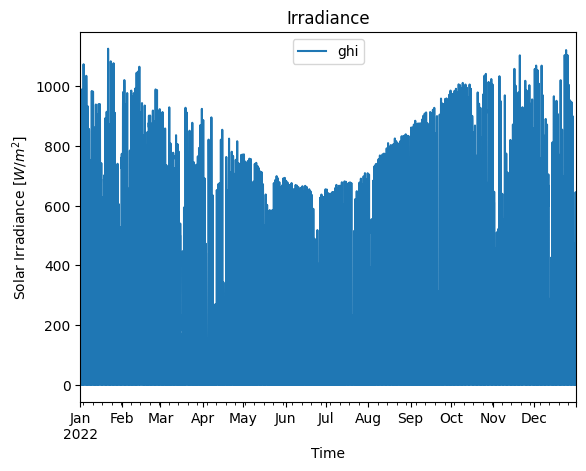

In [19]:
# global horizontal irradiance
era5_wefe.loc[:, ['ghi']].plot(title='Irradiance')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance $[W/m^2]$')

solar_irrad_plot = BytesIO()
plt.savefig(solar_irrad_plot, format='png')

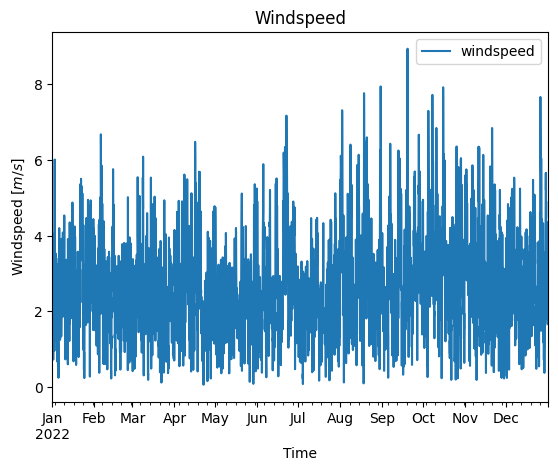

In [20]:
# windspeed
era5_wefe.loc[:, ['windspeed']].plot(title='Windspeed')
plt.xlabel('Time')
plt.ylabel('Windspeed $[m/s]$')

windspeed_plot = BytesIO()
plt.savefig(windspeed_plot, format='png')

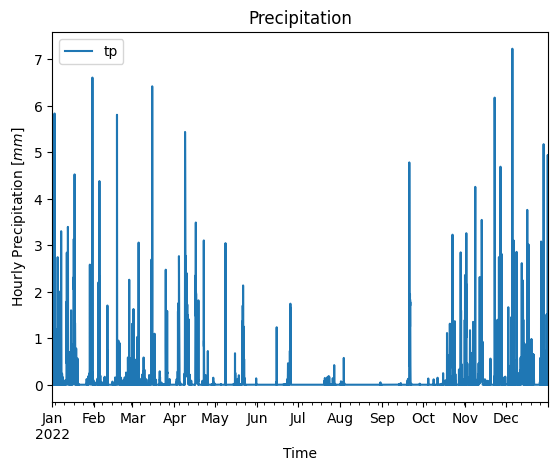

In [21]:
# plot total precipitation
era5_wefe.loc[:, ['tp']].plot(title='Precipitation')
plt.xlabel('Time')
plt.ylabel('Hourly Precipitation $[mm]$')

precip_plot = BytesIO()
plt.savefig(precip_plot, format='png')

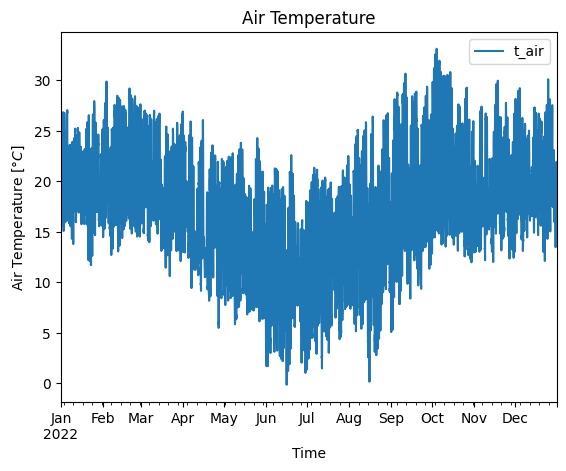

In [22]:
# plot temperature
era5_wefe.loc[:, ['t_air']].plot(title='Air Temperature')
plt.xlabel('Time')
plt.ylabel('Air Temperature $[°C]$')

temp_plot = BytesIO()
plt.savefig(temp_plot, format='png')

In [23]:
# Map Dissemination

# Currently the static maps (png images) are created by the user applying the snapshot tool (upper right corner) of geemap.
# The maps are saved in the folder '/maps', using generic name:
# satellite_map.png, terrain_map.png, landuse_map.png, hydrology_map.png

# Alternatively the maps can be stored as html and used in future web maps
# For including them into the report automatically they can be converted to png.
# However, this feature currently does not work; as the png only show a black screen

# save maps as html

#satellite_map.save('maps/satellite_map.html')
#terrain_map.save('maps/terrain_map.html')
#landuse_map.save('maps/landuse_map.html')
#hydrology_map.save('maps/hydrology_map.html')


# convet html to png

# import imgkit
# Indicate where wkhtmltoimage can be found
# con = imgkit.config(wkhtmltoimage='C:\\Program Files\\wkhtmltopdf\\bin\\wkhtmltoimage.exe')
# "C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe"
# imgkit.from_file('test.html', 'test.png', config=con)


#from html2image import Html2Image

# Initialize the module
#htmlImg = Html2Image()

# Convert an HTML file to an image
#htmlImg.screenshot(html_file='test.html', save_as='test.png')


#terrain_map.layer_to_image('Elevation', output='test_terrain_map.jpg')
#geemap.show_image('test_terrain_map.jpg')

# Save the map as an HTML file
#html_file_path = 'test_map_2_map.html'
#terrain_map.save(html_file_path)

# Open the HTML file in fullscreen mode
#webbrowser.open('file://' + os.path.realpath(html_file_path), new=2)

#output_dir = os.getcwd()
#image_export_path = os.path.join(output_dir, 'terrain_map.jpg')
#geemap.Map.to_image(terrain_map, filename=image_export_path)

# Alternatively the package 'cartoee' could be used to create static maps to be included into the report


In [24]:
## Automated Report Generation

# Function to add a paragraph with specified run style
def add_paragraph_with_styles(doc, parts):
    paragraph = doc.add_paragraph()
    for text, bold, size in parts:
        run = paragraph.add_run(text)
        run.font.bold = bold
        run.font.size = Pt(size)
    return paragraph

# Create a document object
doc = Document()

# Set default font for the entire document
default_style = doc.styles['Normal']
default_style.font.name = 'Calibri'  # Set default font to Calibri
default_style.font.size = Pt(12)  # Set default font size

# Title text for the document
title_text = f"WEFESite Analyst Report: {name} Case Study"
doc.add_heading(title_text, level=0)

# Introductory text
intro_text = (
    "WEFESiteAnalyst is an automatized remote data collection tool for the site-tailored planning of "
    "integrated Water-Energy-Food-Environment Systems (iWEFEs). "
    "This report presents findings and insights from the analysis of the case study for "
    f"{name}. The WEFESite Analyst tool aims to provide valuable information for decision-making and "
    "planning related to environmental factors, site suitability, and more. "
    "Thank you for using WEFESite Analyst for your case study analysis!"
)
add_paragraph_with_styles(doc, [(intro_text, False, 12)])

# Add Satelite Map section
doc.add_heading("Satellite Map", level=1)
satellite_map_image = 'screenshots/satellite_map.png'
doc.add_picture(satellite_map_image, width=Inches(6))


# Add Terrain section
doc.add_heading("Terrain", level=1)
terrain_map_image = 'screenshots/terrain_map.png'
doc.add_picture(terrain_map_image, width=Inches(6))
add_paragraph_with_styles(doc, [("Elevation value at location: ", True, 12), (f'{elevation_value.getInfo()} meters', False, 12)])

# Add Landuse section
doc.add_heading("Landuse", level=1)
landuse_map_image = 'screenshots/landuse_map.png'
doc.add_picture(landuse_map_image, width=Inches(6))

# Add Hydrology section
doc.add_heading("Hydrology", level=1)
hydrology_map_image = 'screenshots/hydrology_map.png'
doc.add_picture(hydrology_map_image, width=Inches(6))

# Add Soil section to report document
doc.add_heading("Soil", level=1)
# Add an empty paragraph for spacing
doc.add_paragraph()

# Selecting only specific columns
selected_columns = ["soil organic carbon [dg/kg]", "bulk density [cg/cm³]", "cation exchange capacity at pH 7 [mmol(c)/kg]", "nitrogen content [cg/kg]"]
df_filtered_soil = soil_properties_df[selected_columns]

# Transpose the DataFrame
df_filtered_soil = df_filtered_soil.T.reset_index()

# Add a table to the document
table_soil = doc.add_table(rows=df_filtered_soil.shape[0] + 1, cols=2)  # +1 for the header row
table_soil.style = 'Light Grid Accent 1'

# Populate the header row
for j, header in enumerate(["Parameter", "Value"]):
    table_soil.cell(0, j).text = header
    table_soil.cell(0, j).vertical_alignment = WD_ALIGN_VERTICAL.CENTER  # Optional: Align text vertically to center

# Populate the table with parameter names and values
for i in range(df_filtered_soil.shape[0]):
    table_soil.cell(i + 1, 0).text = df_filtered_soil.iloc[i, 0]  # Parameter name
    table_soil.cell(i + 1, 1).text = f"{df_filtered_soil.iloc[i, 1]:.2f}"  # Parameter value
    for j in range(2):
        table_soil.cell(i + 1, j).vertical_alignment = WD_ALIGN_VERTICAL.CENTER  # Optional: Align text vertically to center


# Add Climate section
doc.add_heading("Climate", level=1)

# Add Solar Irradiance subsection
doc.add_heading("Solar Irradiance", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Total solar irradiance: ", True, 12), (f'{solar_irrad_total:.2f} kWh/m^2/a', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(solar_irrad_plot, width=Inches(5))
# Retrieve the last paragraph in the document (should be the plot)
solar_irrad_paragraph = doc.paragraphs[-1]
# Set it to center alignment
solar_irrad_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Windspeed subsection
doc.add_heading("Windspeed", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Average windspeed: ", True, 12), (f'{windspeed_mean:.2f} m/s', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(windspeed_plot, width=Inches(5))
# Retrieve the last paragraph in the document (should be the plot)
windspeed_paragraph = doc.paragraphs[-1]
# Set it to center alignment
windspeed_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Precipitation subsection
doc.add_heading("Precipitation", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Total precipitation: ", True, 12), (f'{precip_total:.2f} mm', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(precip_plot, width=Inches(5))
# Retrieve the last paragraph in the document (should be the plot)
precip_paragraph = doc.paragraphs[-1]
# Set it to center alignment
precip_paragraph.alignment = 1
# Add an empty paragraph for spacing
doc.add_paragraph()

# Add Temperature subsection
doc.add_heading("Temperature", level=2)
# Add paragraph with styles
add_paragraph_with_styles(doc, [("Average temperature: ", True, 12), (f'{temp_mean:.2f} °C', False, 12)])
# Insert the saved image into the Word document
doc.add_picture(temp_plot, width=Inches(5))
# Retrieve the last paragraph in the document (should be the plot)
temp_paragraph = doc.paragraphs[-1]
# Set it to center alignment
temp_paragraph.alignment = 1

In [25]:
# Define report filename
report_filename = f'wefe_site_analyst_{name}.docx'
# Save the report
doc.save(report_filename)
display(doc)

In [26]:
# retrieve area of interest from drawing/alternative in case polygon file is not available


center = ee.Geometry.Point(lon, lat)

print("please draw center of demand and area of interest into the map displayed below")


m = gfolium.Map(
    center=[lat, lon], zoom=17, toolbar_control=False, layers_control=True
)

m.add_basemap('SATELLITE')
m.addLayer(center, {'color': 'red', 'weight': 1, 'opacity': 1}, "center")

m


please draw center of demand and area of interest into the map displayed below
